## Section 1: Setup and Imports

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_curve, roc_auc_score
from utils.utils import scores_with_optimal_cutoff, mean_confidence_interval, plot_summarize_curve
import warnings

warnings.filterwarnings('ignore')

In [2]:
groups = [['original'], ['log'], ['wavelet'],
          ['original', 'log'], ['original', 'wavelet'], ['log', 'wavelet'], 
          ['original', 'log', 'wavelet']]

In [3]:
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': xgb.XGBClassifier(objective='binary:logistic', n_estimators=100)
}

## Section 2: Load and Explore Data

In [4]:
npy_path = './data/npy_greenFeature'
folds = os.listdir(npy_path)
folds.sort()
print(folds)

['fold0', 'fold1', 'fold2', 'fold3', 'fold4']


## Section 3: Define function

In [5]:
def read_dataset(basePath, foldNum = 0, type = ['original', 'log', 'wavelet']):
    type_str = '_'.join(type)
    path = os.path.join(basePath, f"fold{foldNum}", f"{type_str}.npy")
    
    if os.path.exists(path):
        dict = np.load(path, allow_pickle=True).item()

    return dict['X_train'], dict['y_train'], dict['X_test'], dict['y_test']


In [6]:
def plot_roc_fold(y_true, y_pred, ax, fold):
    viz = RocCurveDisplay.from_predictions(
            y_true,
            y_pred,
            name="ROC fold {}".format(fold),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
    return ax, viz

In [7]:
def plot_pr_fold(y_true, y_pred, ax, fold):
    viz = PrecisionRecallDisplay.from_predictions(
            y_true,
            y_pred,
            name="PRC fold {}".format(fold),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
    return ax, viz

In [8]:
def plot_mean_curve(ax, ys, mean_x, scores, confidence=0.95, curve='roc'):
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    mean_y = np.mean(ys, axis=0)
    if curve == 'roc':
        ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
        label = r"(AUC = %0.2f $\pm$ %0.2f)" % (mean_score, std_score)
        mean_y[-1] = 1.0
    elif curve == 'prc' or curve == 'pr':
        label=r"Mean PRC (AP = %0.2f $\pm$ %0.2f)" % (mean_score, std_score)
    else:
        raise ValueError(f'{curve} curve is not supported!')

    ax.plot(
        mean_x,
        mean_y,
        color="b",
        label=label,
        lw=2,
        alpha=0.8
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )
    ax.legend(loc="lower right")
    return ax

In [9]:
def save_result(target_folder, fig_roc, fig_pr, out, index='N/A'):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
        
    result = pd.DataFrame(out, index=[index])
    result_file = os.path.join(target_folder, 'cross_val_result.csv')
    
    if os.path.exists(result_file):
        existing_result = pd.read_csv(result_file, index_col=0)
        if index in existing_result.index:
            existing_result.loc[index] = result.loc[index]
        else:
            existing_result = pd.concat([existing_result, result])
        result = existing_result
    
    result.to_csv(result_file, index=True)
    fig_pr.savefig(os.path.join(target_folder, f'{index}_pr_curve.png'), bbox_inches='tight')
    plt.clf()
    fig_roc.savefig(os.path.join(target_folder, f'{index}_roc_curve.png'), bbox_inches='tight')
    plt.clf()

### Cross-validate

In [ ]:
def group_train_and_eval(baseModel, npy_path, group = ['original', 'log', 'wavelet'], confidence = 0.95):
    n_folds = 5
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    precs = []
    mean_recall = np.linspace(1, 0, 100)

    aucs = []
    aps = []

    log_losses = []
    briers = []
    accs = []
    bas = []
    f1s = []
    ses = []
    sps = []

    fig_roc, ax_roc = plt.subplots()
    fig_pr, ax_pr = plt.subplots()

    for fold in range(n_folds):
        X_train, y_train, X_test, y_test = read_dataset(npy_path, fold, group)
        # clf = baseModel.fit(X_train, y_train)
        # y_proba = clf.predict_proba(X_test)[:,1]
        best_auc = 0
        for _ in range(10):
            clf = baseModel.fit(X_train, y_train)
            y_proba = clf.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
            if auc > best_auc:
                best_auc = auc
                best_y_proba = y_proba
        y_proba = best_y_proba

        ax_roc, viz_roc = plot_roc_fold(y_test, y_proba, ax_roc, fold)
        ax_pr, viz_pr = plot_pr_fold(y_test, y_proba, ax_pr, fold)

        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

        interp_prec = np.interp(mean_recall, np.flip(viz_pr.recall), np.flip(viz_pr.precision))
        precs.append(interp_prec)
        aucs.append(viz_roc.roc_auc)
        aps.append(viz_pr.average_precision)

        log_loss_score, brier_score, acc, f1, ba, se, sp = scores_with_optimal_cutoff(tpr, fpr, thresholds, y_test, y_proba)

        
        log_losses.append(log_loss_score)
        briers.append(brier_score)
        accs.append(acc)
        f1s.append(f1)
        bas.append(ba)
        ses.append(se)
        sps.append(sp)

    ax_roc = plot_mean_curve(ax_roc, tprs, mean_fpr, aucs, curve = 'roc')
    ax_pr = plot_mean_curve(ax_pr, precs, mean_recall, aps, curve='pr')

    logloss_mean, logloss_lower, logloss_upper = mean_confidence_interval(log_losses, confidence=confidence)
    brier_mean, brier_lower, brier_upper = mean_confidence_interval(briers, confidence)
    acc_mean, acc_lower, acc_upper = mean_confidence_interval(accs, confidence)
    f1_mean, f1_lower, f1_upper = mean_confidence_interval(f1s, confidence)
    auc_mean, auc_lower, auc_upper = mean_confidence_interval(aucs, confidence)
    ba_mean, ba_lower, ba_upper = mean_confidence_interval(bas, confidence)
    se_mean, se_lower, se_upper = mean_confidence_interval(ses, confidence)
    sp_mean, sp_lower, sp_upper = mean_confidence_interval(sps, confidence)

    out = {}
    out['auc_mean'] = auc_mean
    out['auc_lower'] = max(auc_lower, 0)
    out['auc_upper'] = min(auc_upper, 1)
    out['logloss_mean'] = logloss_mean
    out['logloss_lower'] = max(logloss_lower, 0)
    out['logloss_upper'] = logloss_upper
    out['brier_loss_mean'] = brier_mean
    out['brier_loss_lower'] = max(brier_lower, 0)
    out['brier_loss_upper'] = min(brier_upper, 1)
    out['accuracy_mean'] = acc_mean
    out['accuracy_lower'] = max(acc_lower, 0)
    out['accuracy_upper'] = min(acc_upper, 1)
    out['balanced_accuracy_mean'] = ba_mean
    out['balanced_accuracy_lower'] = max(ba_lower, 0)
    out['balanced_accuracy_upper'] = min(ba_upper, 1)
    out['f1_score_mean'] = f1_mean
    out['f1_score_lower'] = max(f1_lower, 0)
    out['f1_score_upper'] = min(f1_upper, 1)
    out['average_sensibility_mean'] = se_mean
    out['average_sensibility_lower'] = max(se_lower, 0)
    out['average_sensibility_upper'] = min(se_upper, 1)
    out['average_specificity_mean'] = sp_mean
    out['average_specificity_lower'] = max(sp_lower, 0)
    out['average_specificity_upper'] = min(sp_upper, 1)
    
    return fig_roc, fig_pr, out
    

In [ ]:
def experiment_group(baseModel, groups, npy_path, target_folder):
    for group in groups:
        fig_roc, fig_pr, out = group_train_and_eval(baseModel= baseModel, npy_path=npy_path, group = group)
        save_result(target_folder, fig_roc, fig_pr, out, index = '+'.join(group))
        

In [ ]:
for name, model in models.items():
    experiment_group(baseModel=model, groups = groups, npy_path= npy_path, target_folder=f'./res/{name}')


### MLP

In [ ]:
param = {
    'hidden_layer_sizes': (32, 16, ),
    'activation': 'relu',
    'solver': 'adam',
    'batch_size': 4,
    'max_iter': 100,
    'learning_rate_init': 0.001
}

best_model = None
best_auc_mean = 0.0
best_iteration = None

In [ ]:
def MLP_train(baseModel, npy_path, group = ['original', 'log', 'wavelet'], confidence = 0.95):
    n_folds = 5
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    precs = []
    mean_recall = np.linspace(1, 0, 100)

    aucs = []
    aps = []

    log_losses = []
    briers = []
    accs = []
    bas = []
    f1s = []
    ses = []
    sps = []

    fig_roc, ax_roc = plt.subplots()
    fig_pr, ax_pr = plt.subplots()

    for fold in range(n_folds):
        X_train, y_train, X_test, y_test = read_dataset(npy_path, fold, group)
        
        # if fold == 0:
        #     clf = baseModel.fit(X_train, y_train)
        #     tuned_params = clf.get_params()
        # else:
        #     clf = MLPClassifier(**tuned_params).fit(X_train, y_train)

        best_auc = 0.0
        if os.path.exists(f'params/{"_".join(group)}-{fold}.pkl'):
            with open(f'params/{"_".join(group)}-{fold}.pkl', 'rb') as f:
                clf = pkl.load(f)
                y_proba = clf.predict_proba(X_test)[:,1]
                best_auc = roc_auc_score(y_test, y_proba)
                best_iteration = -1

        for iteration in tqdm(range(100), desc=f"Group: {'+'.join(group)}, Fold: {fold}"):
            clf = baseModel.fit(X_train, y_train)    
            temp_proba = clf.predict_proba(X_test)[:,1]
            auc = roc_auc_score(y_test, temp_proba)
            if auc > best_auc:
                best_auc = auc
                y_proba = temp_proba
                best_iteration = iteration
                with open(f'params/{"_".join(group)}-{fold}.pkl', 'wb') as f:
                    pkl.dump(clf, f)

        print(f"Best AUC: {best_auc} at iteration: {best_iteration}")   
        ax_roc, viz_roc = plot_roc_fold(y_test, y_proba, ax_roc, fold)
        ax_pr, viz_pr = plot_pr_fold(y_test, y_proba, ax_pr, fold)

        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

        interp_prec = np.interp(mean_recall, np.flip(viz_pr.recall), np.flip(viz_pr.precision))
        precs.append(interp_prec)
        aucs.append(viz_roc.roc_auc)
        aps.append(viz_pr.average_precision)

        log_loss_score, brier_score, acc, f1, ba, se, sp = scores_with_optimal_cutoff(tpr, fpr, thresholds, y_test, y_proba)
        log_losses.append(log_loss_score)
        briers.append(brier_score)
        accs.append(acc)
        f1s.append(f1)
        bas.append(ba)
        ses.append(se)
        sps.append(sp)

    ax_roc = plot_mean_curve(ax_roc, tprs, mean_fpr, aucs, curve = 'roc')
    ax_pr = plot_mean_curve(ax_pr, precs, mean_recall, aps, curve='pr')

    logloss_mean, logloss_lower, logloss_upper = mean_confidence_interval(log_losses, confidence=confidence)
    brier_mean, brier_lower, brier_upper = mean_confidence_interval(briers, confidence)
    acc_mean, acc_lower, acc_upper = mean_confidence_interval(accs, confidence)
    f1_mean, f1_lower, f1_upper = mean_confidence_interval(f1s, confidence)
    auc_mean, auc_lower, auc_upper = mean_confidence_interval(aucs, confidence)
    ba_mean, ba_lower, ba_upper = mean_confidence_interval(bas, confidence)
    se_mean, se_lower, se_upper = mean_confidence_interval(ses, confidence)
    sp_mean, sp_lower, sp_upper = mean_confidence_interval(sps, confidence)

    out = {}
    out['auc_mean'] = auc_mean
    out['auc_lower'] = max(auc_lower, 0)
    out['auc_upper'] = min(auc_upper, 1)
    out['logloss_mean'] = logloss_mean
    out['logloss_lower'] = max(logloss_lower, 0)
    out['logloss_upper'] = logloss_upper
    out['brier_loss_mean'] = brier_mean
    out['brier_loss_lower'] = max(brier_lower, 0)
    out['brier_loss_upper'] = min(brier_upper, 1)
    out['accuracy_mean'] = acc_mean
    out['accuracy_lower'] = max(acc_lower, 0)
    out['accuracy_upper'] = min(acc_upper, 1)
    out['balanced_accuracy_mean'] = ba_mean
    out['balanced_accuracy_lower'] = max(ba_lower, 0)
    out['balanced_accuracy_upper'] = min(ba_upper, 1)
    out['f1_score_mean'] = f1_mean
    out['f1_score_lower'] = max(f1_lower, 0)
    out['f1_score_upper'] = min(f1_upper, 1)
    out['average_sensibility_mean'] = se_mean
    out['average_sensibility_lower'] = max(se_lower, 0)
    out['average_sensibility_upper'] = min(se_upper, 1)
    out['average_specificity_mean'] = sp_mean
    out['average_specificity_lower'] = max(sp_lower, 0)
    out['average_specificity_upper'] = min(sp_upper, 1)
    return fig_roc, fig_pr, out, clf
    

In [ ]:
target_folder = './res/MLP'
for group in groups:
    best_iteration = None
    best_fig_roc = None
    best_fig_pr = None

    df_path = os.path.join(target_folder,'cross_val_result.csv')
    if os.path.exists(df_path):
        out = pd.read_csv(df_path)
        if not out.empty and '+'.join(group) in out.iloc[:, 0].values:
            best_auc_mean = out[out.iloc[:, 0] == '+'.join(group)]['auc_mean'].values[0]
        else:
            best_auc_mean = 0.0
    else: 
        best_auc_mean = 0.0

    # for iteration in tqdm(range(100), desc=f"Group: {'+'.join(group)}"):
    base_model = MLPClassifier(**param)
    fig_roc, fig_pr, out, clf = MLP_train(base_model, npy_path=npy_path, group=group)
    # plt.close(fig_roc)
    # plt.close(fig_pr)
    print(out['auc_mean'])
    if (out['auc_mean']) > best_auc_mean:
        best_auc_mean = out['auc_mean']
        best_model = clf

        # Save the model
        with open(f"{'_'.join(group)}.pkl", 'wb') as f:
            pkl.dump(best_model, f)

        save_result(target_folder, fig_roc, fig_pr, out, index = '+'.join(group))

        # print(f"Saved model for {group} with AUC: {best_auc_mean:.4f} at iteration {iteration + 1}")  


### TESTSET

In [13]:
def read_test_dataset(basePath, type=['original', 'log', 'wavelet']):
    type_str = '_'.join(type)
    path = os.path.join(basePath, f"{type_str}.npy")
    
    if os.path.exists(path):
        dict = np.load(path, allow_pickle=True).item()

    return dict

In [14]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, balanced_accuracy_score

def get_predict_proba(pkl_file, X, y_true):
    if not os.path.exists(pkl_file):
        raise FileNotFoundError(f"The pickle file {pkl_file} does not exist.")
    
    with open(pkl_file, 'rb') as f:
        model = pkl.load(f)
    
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)
    
    auc = roc_auc_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    out = {
        'AUC': auc,
        'F1-score': f1,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Balanced Accuracy': bal_acc
    }
    
    return y_proba, out

In [ ]:
def evaluate_model_on_test_set(pkl_path, pkl_name, fig, ax, X_test, y_test, group):
    pkl_file = os.path.join(pkl_path, pkl_name)
    y_proba, metrics = get_predict_proba(pkl_file, X_test, y_test)

    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    group_name = '+'.join(['Original' if g == 'original' else 'LoG' if g == 'log' else 'Wavelet' for g in group])
    ax.plot(fpr, tpr, lw=2, label=f'{group} (AUC = {roc_auc:.2f})')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

    return metrics

In [ ]:
pkl_path = "./test_param"
pkls = os.listdir(pkl_path)
pkls.sort()
res_path = './testres'

test_npy_path = './data/TEST/npy'

Metrics for log.pkl: {'AUC': 0.825, 'F1-score': 0.7142857142857143, 'Sensitivity': 0.625, 'Specificity': 0.9, 'Balanced Accuracy': 0.7625}
Metrics for log_wavelet.pkl: {'AUC': 0.75, 'F1-score': 0.6666666666666666, 'Sensitivity': 0.625, 'Specificity': 0.8, 'Balanced Accuracy': 0.7125}
Metrics for original.pkl: {'AUC': 0.725, 'F1-score': 0.7058823529411765, 'Sensitivity': 0.75, 'Specificity': 0.7, 'Balanced Accuracy': 0.725}
Metrics for original_log.pkl: {'AUC': 0.9187500000000001, 'F1-score': 0.9411764705882353, 'Sensitivity': 1.0, 'Specificity': 0.9, 'Balanced Accuracy': 0.95}
Metrics for original_log_wavelet.pkl: {'AUC': 0.75, 'F1-score': 0.6666666666666665, 'Sensitivity': 0.75, 'Specificity': 0.6, 'Balanced Accuracy': 0.675}
Metrics for original_wavelet.pkl: {'AUC': 0.76875, 'F1-score': 0.6666666666666665, 'Sensitivity': 0.75, 'Specificity': 0.6, 'Balanced Accuracy': 0.675}
Metrics for wavelet.pkl: {'AUC': 0.7125, 'F1-score': 0.6666666666666667, 'Sensitivity': 0.875, 'Specificity': 0

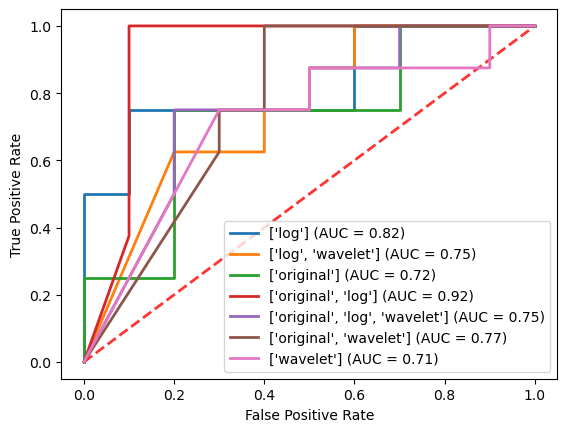

In [ ]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

for pkl_file in pkls:
    if pkl_file.endswith('.pkl'):
        group = re.split(r'_\d*\.pkl$', pkl_file)[0].split('_')
        group = [g.replace('.pkl', '') for g in group]
        # print(group)
        ddict = read_test_dataset(test_npy_path, type = group)
        X_test, y_test = ddict['feature'], ddict['label']
        metrics = evaluate_model_on_test_set(pkl_path, pkl_file, fig, ax, X_test, y_test, group = group)
        print(f"Metrics for {pkl_file}: {metrics}")

        # Save metrics to CSV
        result = pd.DataFrame(metrics, index=[pkl_file])
        result_file = os.path.join(res_path, 'testset.csv')
        
        if os.path.exists(result_file):
            existing_result = pd.read_csv(result_file, index_col=0)
            if pkl_file in existing_result.index:
                existing_result.loc[pkl_file] = result.loc[pkl_file]
            else:
                existing_result = pd.concat([existing_result, result])
            result = existing_result
        else:
            result = pd.concat([result])
        
        result.to_csv(result_file, index=True)